### Imports

In [1]:
import os
import glob
import argparse
import time
from PIL import Image
import numpy as np
import PIL
import h5py
import cv2

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from tensorflow.keras.models import load_model
from layers import BilinearUpSampling2D
from loss import depth_loss_function
from utils import predict, display_images
from matplotlib import pyplot as plt

c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (

### Load Model

In [2]:
# Argument Parser
parser = argparse.ArgumentParser(description='High Quality Monocular Depth Estimation via Transfer Learning')
parser.add_argument('--model', default='nyu.h5', type=str, help='Trained Keras model file.')
parser.add_argument('--traininput', default='my_examples/*.jpg', type=str, help='Training input filename or folder.')
parser.add_argument('--testinput', default='test_images/*.jpg', type=str, help='Testing input filename or folder.')
args, unknown = parser.parse_known_args()

# Custom object needed for inference and training
start = time.time()
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(args.model, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(args.model))

Loading model...
Instructions for updating:
Colocations handled automatically by placer.

Model loaded (nyu.h5).


### Predict Heatmap Image

In [3]:
def load_images_with_resize(image_files):
    loaded_images = []
    for file in image_files:
        im = Image.open( file )
        im = im.resize((640, 480), PIL.Image.ANTIALIAS)
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

def DepthNorm(x, maxDepth):
    return maxDepth / x

# Input images
inputs = load_images_with_resize( glob.glob(args.traininput) )
print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)

end = time.time()
print('It took: ', end - start)


Loaded (1) images of size (480, 640, 3).


c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  """


(240, 320, 1)
It took:  24.242284536361694


### Display Image

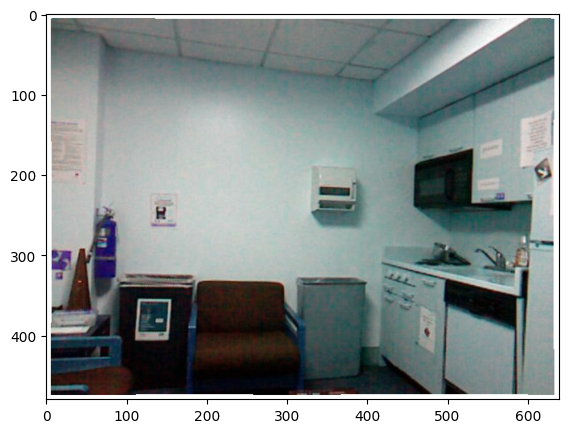

In [4]:
# Normal Image
rgb_image = cv2.imread('my_examples/img-office.jpg')
plt.figure(figsize=(10,5))
out = plt.imshow(rgb_image)

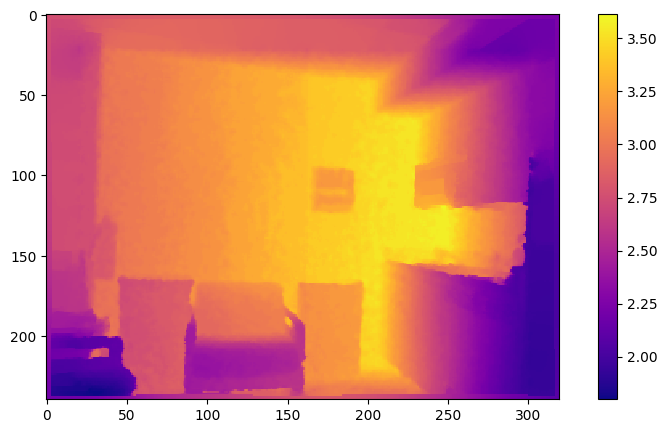

In [5]:
# Display Ground-Truth Image
f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
nyu_depths = f['depths']
nyu_depth_image = nyu_depths[0]
nyu_depth_image = cv2.rotate(nyu_depth_image, cv2.ROTATE_90_CLOCKWISE)
nyu_depth_image = cv2.flip(nyu_depth_image, 1)

# Delete every other row and column of the array so it matched dimensions of out predicted image
def condense_image(image_src):
    image = np.copy(image_src)
    for row in reversed(range(len(image))):
        if row % 2 != 0:
            image = np.delete(image, row, 0)

    for column in reversed(range(len(image[0]))):
        if column % 2 != 0:
            image = np.delete(image, column, 1)
    return image

true_depth_image = condense_image(nyu_depth_image)

plt.figure(figsize=(10,5))
out = plt.imshow(true_depth_image, cmap='plasma', interpolation='nearest')
out = plt.colorbar()

Value Range: 0.0 - 1.0
(240, 320, 1)


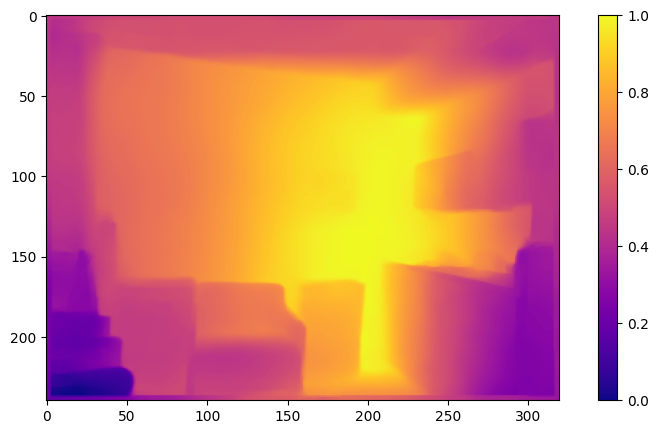

In [6]:
# Display Predicted Image
def normalize_image(image):
    min = np.min(image)
    max = np.max(image)
    return (image - min) / (max - min)

def display(image):
    print("Value Range:", image.min(), "-", image.max())
    print(image.shape)
    plt.figure(figsize=(10,5))
    out = plt.imshow(image, cmap='plasma')
    out = plt.colorbar()

predicted_image = normalize_image(np.asarray(outputs[0])) # This output can be messed with however now
display(predicted_image)
# plt.savefig('results.png')

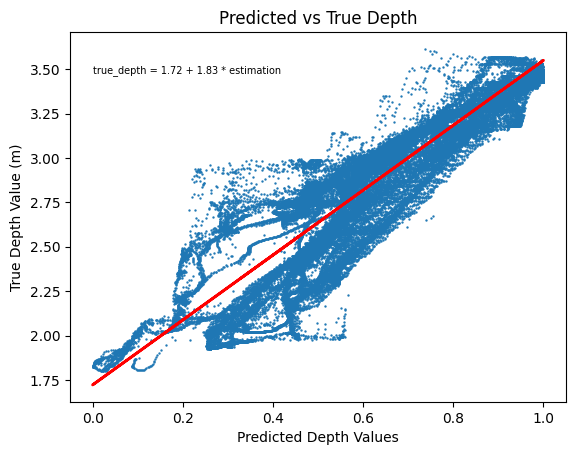

In [7]:
# Display the two images as a function between each other
x_axis = predicted_image.flatten()
y_axis = true_depth_image.flatten()

a, b = np.polyfit(x_axis, y_axis, 1)

plt.scatter(x_axis, y_axis, s=0.5)
plt.title('Predicted vs True Depth')
plt.xlabel('Predicted Depth Values')
plt.ylabel('True Depth Value (m)')
plt.plot(x_axis, a*x_axis + b, linewidth=2, color='red')
plt.text(0, 3.48, 'true_depth = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + ' * estimation', size=7)
plt.show()

c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  """



Loaded (2) images of size (480, 640, 3).
(240, 320, 1)
Done with prediction(s)


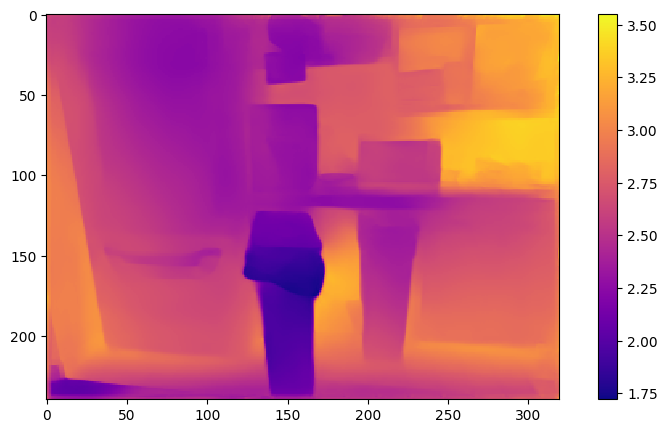

In [8]:
# Apply the equation to a new image
inputs_for_test = load_images_with_resize(glob.glob(args.testinput))
print('\nLoaded ({0}) images of size {1}.'.format(inputs_for_test.shape[0], inputs_for_test.shape[1:]))
new_outputs = predict(model, inputs_for_test)
print('Done with prediction(s)')

new_predicted_image = normalize_image(np.asarray(new_outputs[0])) # This output can be messed with however now
new_true_depth_estimate = a * new_predicted_image + b
plt.figure(figsize=(10,5))
out = plt.imshow(new_true_depth_estimate, cmap='plasma', interpolation='nearest')
out = plt.colorbar()